In [1]:
import control
import scipy.integrate
import numpy as np
import matplotlib.pyplot as plt
import math
from sortedcontainers import SortedDict

plt.style.use('dark_background')

In [67]:
Mmotor = 0.086
Mfly = 0.0357 * 183.594 / 280.698
rdisk = 0.0617318752905765
La = 0.10
Ifly = 4.85E-5 * 3.707 / 5.370 # Mfly * rdisk ** 2 / 2
Ifly_ctr = Ifly + Mfly * La ** 2
Itot = (Ifly_ctr + Mmotor * La) # nah never mind # * 2 # I _think_ it's x2 because in the inertial frame the Earth is the other part of that arm
Mtot = Mmotor + Mfly
g = 9.8
b = 0.387 # accel per rad/s

A = np.array([[ 0, 1, 0 ], [ Mtot * La / 2 * g / Itot, 0, 0 ], [ 0, 0, -b ]])
B = np.array([ 0, -Ifly / Itot, 1 ]).reshape((-1, 1))
Q = np.diag([ 0.1, 0.001, 50 ])
R = np.array([ 100 ])

In [102]:
RAD_PER_PWMIN = 0.2 / 128 / 7.78
CTRL_T = 0.003 # control loop nominal tick period
RAD_PER_TICK = math.pi * 2 / 42 # radians per flywheel hall tick
TICK_T = 1E-6 # flywheel tick nominal period
L = [
    RAD_PER_PWMIN, # rad / pwmin ticks
    RAD_PER_PWMIN / CTRL_T / 256, # rad/s / diff_d
    1.0, # rad/s / speed_avg
]
K = control.lqr(A, B, Q, R)[0]
# K = np.array(list(np.array(K)[0]) + [0]).reshape((1,-1)) # pad by 1
print(K)
print(np.array(K) * L)

[[-3.67222785e+03 -1.49386039e+03 -3.05077081e-01]]
[[-0.73751363 -0.39065125 -0.30507708]]


In [48]:
T0 = 0.6
VDD = 7.6
KV = 1060
Vmax = VDD * KV / 60 * math.pi * 2

In [97]:
sigma = 0.1
sigma_v = 0.1
T = np.arange(0, 20, 0.1)
N = np.random.normal(scale=1, size=(2,) + T.shape) * [[sigma], [sigma_v]]
SS = control.StateSpace(A - np.dot(B, K), np.array([[1, 0, 0], [ 0, 1, 0 ]]).T, np.eye(A.shape[0]), np.zeros((A.shape[1], 2)))
X0 = (0.1, 0, 0)
Tout, _, xout = control.forced_response(SS, T, N, X0=X0)

<Figure size 432x288 with 0 Axes>

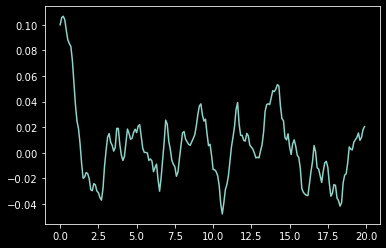

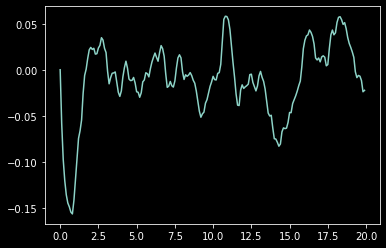

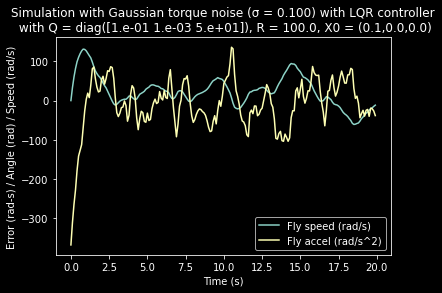

In [98]:
plt.figure()
[plt.figure() and plt.plot(Tout, x) for x in xout]
plt.xlabel('Time (s)')
plt.ylabel('Error (rad-s) / Angle (rad) / Speed (rad/s)')
plt.title('Simulation with Gaussian torque noise (σ = %.3f) with LQR controller\n with Q = diag(%s), R = %.1f, X0 = (%s)' % (sigma, str(np.diag(Q)), R, ",".join(["%.1f" % x for x in X0])))
plt.plot(Tout, np.dot(np.array(K), xout).squeeze())
# plt.plot(Tout, -(1 - abs(xout[2]) / Vmax) * T0, 'tab:purple')
# plt.plot(Tout, (1 - abs(xout[2]) / Vmax) * T0, 'tab:purple')
plt.legend(['Fly speed (rad/s)', 'Fly accel (rad/s^2)']) # , 'Flywheel speed (rad/s)', 'Control torque (N-m)'])